In [1]:
import os
from collections import Counter
from pathlib import Path
from PIL import Image
import numpy as np
import math
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import hashlib


Vérifier si une image est valide

In [46]:
def is_image_valid(path):
    """
    Retourne True si l’image peut être ouverte et vérifiée par PIL, False sinon.
    """
    try:
        with Image.open(path) as img:
            img.verify()
        return True
    except Exception:
        return False

Vérifier si une image est toute noire

In [47]:
def is_black_image(path, threshold=5):
    """
    Retourne True si la moyenne des niveaux de gris de l’image est < threshold (sur 255).
    """
    try:
        with Image.open(path).convert("L") as img_gray:
            arr = np.array(img_gray)
        return arr.mean() < threshold
    except Exception:
        # En cas d’échec de lecture, on considère que l’image n’est pas noire (car elle sera déjà exclue ailleurs)
        return False

Fonction principale : collect_image_metadata

In [48]:
def collect_image_metadata(root_dir, black_threshold=5):
    data = []
    nb_corrupted = 0  # compteur d’images corrompues

    for dirpath, _, filenames in os.walk(root_dir):
        for fname in filenames:
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(dirpath, fname)
                
                if not is_image_valid(img_path):
                    nb_corrupted += 1
                    continue

                is_black = is_black_image(img_path, threshold=black_threshold)
                relative = os.path.relpath(img_path, root_dir)
                split = relative.split(os.sep)
                if len(split) < 2:
                    continue
                dossier = split[0]
                try:
                    nom_plante, nom_maladie = dossier.split('___')
                except Exception:
                    nom_plante, nom_maladie = dossier, "Unknown"
                est_saine = (nom_maladie.lower() == "healthy")
                try:
                    with Image.open(img_path) as img:
                        width, height = img.size
                except Exception:
                    width, height = None, None

                data.append({
                    "nom_plante": nom_plante,
                    "nom_maladie": nom_maladie,
                    "Est_Saine": est_saine,
                    "Image_Path": img_path,
                    "width_img": width,
                    "height_img": height,
                    "is_black": is_black
                })
    print(f"Nombre d’images corrompues ignorées : {nb_corrupted}")
    return pd.DataFrame(data)

In [49]:
root_dir = r'C:\Users\bgasm\Documents\Bernadette\IA\projet\notebook_rendu_1\version_7_new_features\plantvillage dataset\segmented' 

df = collect_image_metadata(root_dir, black_threshold=5)
print(df.head())
print(f"{len(df)} images valides conservées.")


Nombre d’images corrompues ignorées : 0
  nom_plante nom_maladie  Est_Saine  \
0      Apple  Apple_scab      False   
1      Apple  Apple_scab      False   
2      Apple  Apple_scab      False   
3      Apple  Apple_scab      False   
4      Apple  Apple_scab      False   

                                          Image_Path  width_img  height_img  \
0  C:\Users\bgasm\Documents\Bernadette\IA\projet\...        256         256   
1  C:\Users\bgasm\Documents\Bernadette\IA\projet\...        256         256   
2  C:\Users\bgasm\Documents\Bernadette\IA\projet\...        256         256   
3  C:\Users\bgasm\Documents\Bernadette\IA\projet\...        256         256   
4  C:\Users\bgasm\Documents\Bernadette\IA\projet\...        256         256   

   is_black  
0     False  
1     False  
2     False  
3     False  
4     False  
54285 images valides conservées.


In [50]:
def show_black_images(df, n=18):
    """
    Affiche jusqu'à n images 'presque noires' du DataFrame df (is_black == True), en subplots.
    """
    black_imgs = df[df['is_black'] == True]
    total = len(black_imgs)
    print(f"Nombre d’images presque noires détectées : {total}")

    imgs_to_show = black_imgs.head(n)
    nb = len(imgs_to_show)
    if nb == 0:
        print("Aucune image noire à afficher.")
        return

    # Définir la grille (ici 3 lignes x 6 colonnes)
    ncols = 6
    nrows = (nb + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 3 * nrows))
    axes = axes.flatten()

    for i, (_, row) in enumerate(imgs_to_show.iterrows()):
        img = Image.open(row['Image_Path'])
        axes[i].imshow(img)
        axes[i].set_title(f"{row['Image_Path'].split(os.sep)[-2]}\n{os.path.basename(row['Image_Path'])}", fontsize=8)
        axes[i].axis('off')

    # Masquer les cases vides s'il y en a
    for j in range(nb, nrows * ncols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

Nombre d’images presque noires détectées : 18


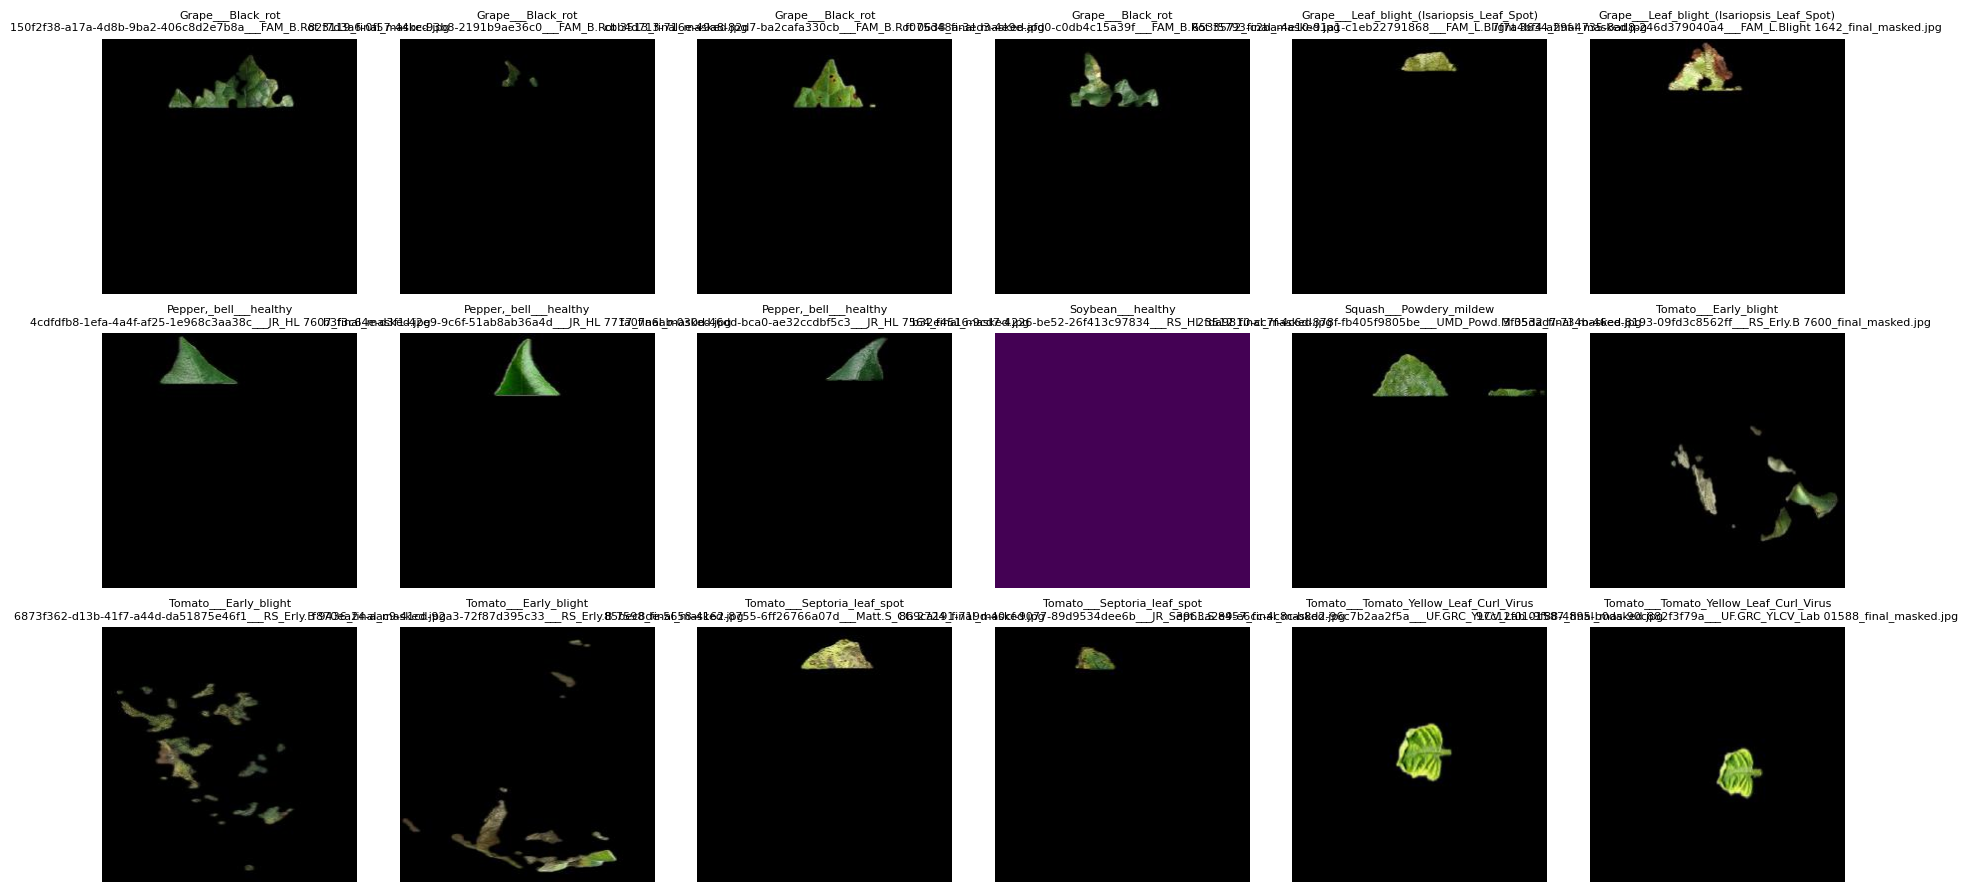

In [51]:
show_black_images(df, n=18)

Identification des doublons

In [52]:
def compute_md5(path):
    try:
        with open(path, 'rb') as f:
            return hashlib.md5(f.read()).hexdigest()
    except Exception as e:
        print(f"Erreur MD5 {path}: {e}")
        return None

# Ajoute la colonne md5
df['md5'] = df['Image_Path'].apply(compute_md5)

# Identifie les doublons (même hash, donc contenu identique)
df['is_duplicate'] = df.duplicated(subset=['md5'], keep='first') & df['md5'].notnull()

In [53]:
dups = df[df['is_duplicate']].copy()

Afficher les doublons par espèce et maladie

Table simple espèce/maladie/chemin

In [54]:
if not dups.empty:
    dups = dups.sort_values(['nom_plante', 'nom_maladie'])
    fig = px.scatter(
        dups,
        x='nom_plante',
        y='nom_maladie',
        hover_data=['Image_Path'],
        color='nom_maladie',
        symbol='nom_plante',
        title='Doublons par espèce et maladie'
    )
    fig.update_traces(marker=dict(size=14, opacity=0.7))
    fig.show()
else:
    print("Aucun doublon trouvé !")

Aucun doublon trouvé !


In [55]:
# Sauvegarde du dataframe df_raw_data en fichier .csv
df.to_csv("Plant_V_Seg_clean.csv", index=False)

In [56]:
df = pd.read_csv('Plant_V_Seg_clean.csv')
df.columns

Index(['nom_plante', 'nom_maladie', 'Est_Saine', 'Image_Path', 'width_img',
       'height_img', 'is_black', 'md5', 'is_duplicate'],
      dtype='object')